In [1]:
#Start of import section
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import csv
import pandas
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Conv2D, Activation, Cropping2D, MaxPooling2D, Dropout, Reshape, Convolution2D
#from keras.layers import softmax
from os import listdir
from os.path import isfile, join
import glob
#end of import section
#include all the imports within this section.

Using TensorFlow backend.
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [7]:
#Implementation The Nvidia end to end driving neural net architecture. 
#Added a dropout layer after the 1st convolution_layer to  mitigate overfitting
#Default drop probablity for any dropout layer added is kept at 0.2.
def NvidiaNet(drop_prob = 0.2):
    #create a sequential Model
    model = Sequential()
    
    #Add a Cropping layer to trim the unneeded portions of the IMAGE from the feed
    #model.add(Cropping2D)
    #model.add(Reshape((50,50,3), input_shape=(None,None,3))
    model.add(Cropping2D(cropping = ((0, 0), (0,0)), input_shape = (100 ,100 ,3)))
    
    #Normalization Layer
    #model.add(Lambda(lambda X_input: (X_input/255.0 - 0.5)))

    #Conv2D Layer 1 with 5 x 5 kernal size
    #model.add(Convolution2D(nb_filter = 3, nb_row = 5, nb_col = 5))
    model.add(Convolution2D(nb_filter = 3, nb_row = 3, nb_col = 3, subsample=(1,1)))
    model.add(Activation('relu'))

    #Dropout layer
    model.add(Dropout(drop_prob))
    
    #Conv2D Layer 2 with 5 x 5 kernal size
    #model.add(Convolution2D(nb_filter = 24, nb_row = 5, nb_col = 5))
    model.add(Conv2D(nb_filter = 24, nb_row = 3, nb_col = 3,subsample=(2,2)))
    model.add(Activation('relu'))

    #Conv2D Layer 3 with 5 x 5 kernal size
    #model.add(Convolution2D(nb_filter = 36, nb_row = 5, nb_col =  5))
    model.add(Conv2D(nb_filter = 36, nb_row = 3, nb_col =  3,subsample=(1,1)))
    model.add(Activation('relu'))
    
    #Dropout layer
    model.add(Dropout(drop_prob))

    #Conv2D Layer 4 with 3 x 3 kernal size
    #model.add(Convolution2D(nb_filter = 48, nb_row = 3, nb_col = 3))
    model.add(Conv2D(nb_filter = 48, nb_row = 3, nb_col = 3))
    model.add(Activation('relu'))

    #Conv2D Layer 5 with 3 x 3 kernal size
    #model.add(Convolution2D(nb_filter = 48, nb_row = 3, nb_col = 3))
    model.add(Conv2D(nb_filter = 64, nb_row = 3, nb_col = 3))
    model.add(Activation('relu'))

    #flatten layer
    #flatten the output from convolution Layer
    model.add(Flatten())

    #Fully connected layer 1
    model.add(Dense(output_dim = 50))

    #Fully connected Layer 2
    model.add(Dense(output_dim = 25))

    #Fully connected Layer 3
    model.add(Dense(output_dim = 10))

    #output Layers
    model.add(Dense(output_dim = 2, activation='softmax') )

    return model


In [4]:
model = NvidiaNet(drop_prob = 0.2)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 98, 98, 3)         84        
_________________________________________________________________
activation_1 (Activation)    (None, 98, 98, 3)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 98, 98, 3)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 24)        672       
_________________________________________________________________
activation_2 (Activation)    (None, 48, 48, 24)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 46, 46, 36)        7812      
__________

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(kernel_size=(3, 3), filters=3, strides=(1, 1))`
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(kernel_size=(3, 3), filters=24, strides=(2, 2))`
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(kernel_size=(3, 3), filters=36, strides=(1, 1))`
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:39: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(kernel_size=(3, 3), filters=48)`
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:44: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(kernel_size=(3, 3), f

In [2]:

def list_files(path):
    #files = [f for f in listdir(path) if isfile(join(path, f))]
    #return files
    return glob.glob(path)

#Perform horizontal flip and return the image and angles
def horizontal_flip(img, angle):
    hor_flip = cv2.flip(img, 0)
    return hor_flip, -1 * angle

#Takes a image path as input and reads the corresponding image from the disk present in the ./data path.
#converts the image to RGB color model and returns it.
def read_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (100, 100))
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #print(rgb.shape)
    return rgb


#outputs the images and the measurements for the corresponding images persistantly as a subroutine
def generator(samples, batch_size = 32): 
    num_samples = len(samples)
    while 1: #to run the generator indefinitely, pumping the X, Y sets for the neural network
        #shuffle the samples on each EPOCH
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset: offset + batch_size]
            
            images = []
            labels = []

            for batch_sample in batch_samples:
                
                '''
                read the image from center camera directly from the disk. 
                No color model conversion performed for the center image
                center image flipped and taken as input irrespective of the center angle.
                '''
                
                name =  batch_sample[0]
                image = read_image(name)
                images.append(image)
                labels.append(batch_sample[1])
                #flip_output = horizontal_flip(center_image, center_angle)
                #images.append(flip_output[0])
                #angles.append(flip_output[1])
                
                
            #Convert the cv2 images and the measurements into numpy array
            X_train = np.array(images)
            Y_train = np.array(labels)
            yield sklearn.utils.shuffle(X_train, Y_train)


In [3]:
def process_files(list_files, label):
    output = []
    for i in list_files:
        temp = []
        temp.append(i)
        l = [0, 0]
        l[label] = 1
        temp.append(l)
        output.append(temp)
    return output

#print(process_files(['a','b','c','d'], 0))

In [4]:
samples_fishing_list = list_files("./fishing_images/fishing/*.jpg")
samples_not_fishing_list = list_files("./fishing_images/not_fishing/*.jpg") + list_files("./fishing_images/not_fishing_1/*.jpg")

samples = process_files(samples_fishing_list, 0) + process_files(samples_not_fishing_list, 0)

img = read_image(samples[0][0])
#print(img.shape)

In [5]:
#testing

train_samples, validation_samples = train_test_split(samples, test_size=0.2)
print(train_samples[1])

['./fishing_images/not_fishing_1/image_3326.jpg', [1, 0]]


In [8]:
#The execution portion of the code.
#save a model

model = NvidiaNet(drop_prob = 0.2)
model.summary()
model.compile(loss='mse', optimizer='adam')


sklearn.utils.shuffle(samples)
train_samples, validation_samples = train_test_split(samples, test_size=0.2)
print(train_samples[1])

#Hyperparameters
train_generator = generator(train_samples, 2)
validation_generator = generator(validation_samples)
epoch = 1
#end of hyperparameters

history = model.fit_generator(train_generator, samples_per_epoch = len(train_samples)*3, validation_data = validation_generator,\
                   nb_val_samples = len(validation_samples), nb_epoch = epoch)
model.save("model.h5")
print("Model Generated")



/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(strides=(1, 1), filters=3, kernel_size=(3, 3))`
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(strides=(2, 2), filters=24, kernel_size=(3, 3))`
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(strides=(1, 1), filters=36, kernel_size=(3, 3))`
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:39: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=48, kernel_size=(3, 3))`
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:44: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=64, kernel_si

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 98, 98, 3)         84        
_________________________________________________________________
activation_1 (Activation)    (None, 98, 98, 3)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 98, 98, 3)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 24)        672       
_________________________________________________________________
activation_2 (Activation)    (None, 48, 48, 24)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 46, 46, 36)        7812      
__________

dict_keys(['val_loss', 'loss'])


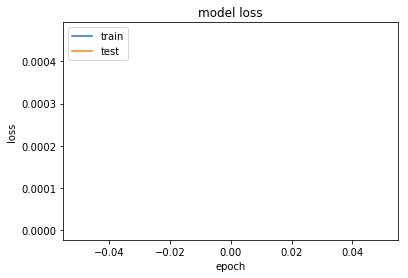

In [9]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

['IMG/center_2016_12_01_13_43_35_934.jpg', ' IMG/left_2016_12_01_13_43_35_934.jpg', ' IMG/right_2016_12_01_13_43_35_934.jpg', ' -0.05975719', ' 0.9855326', ' 0', ' 30.18634']


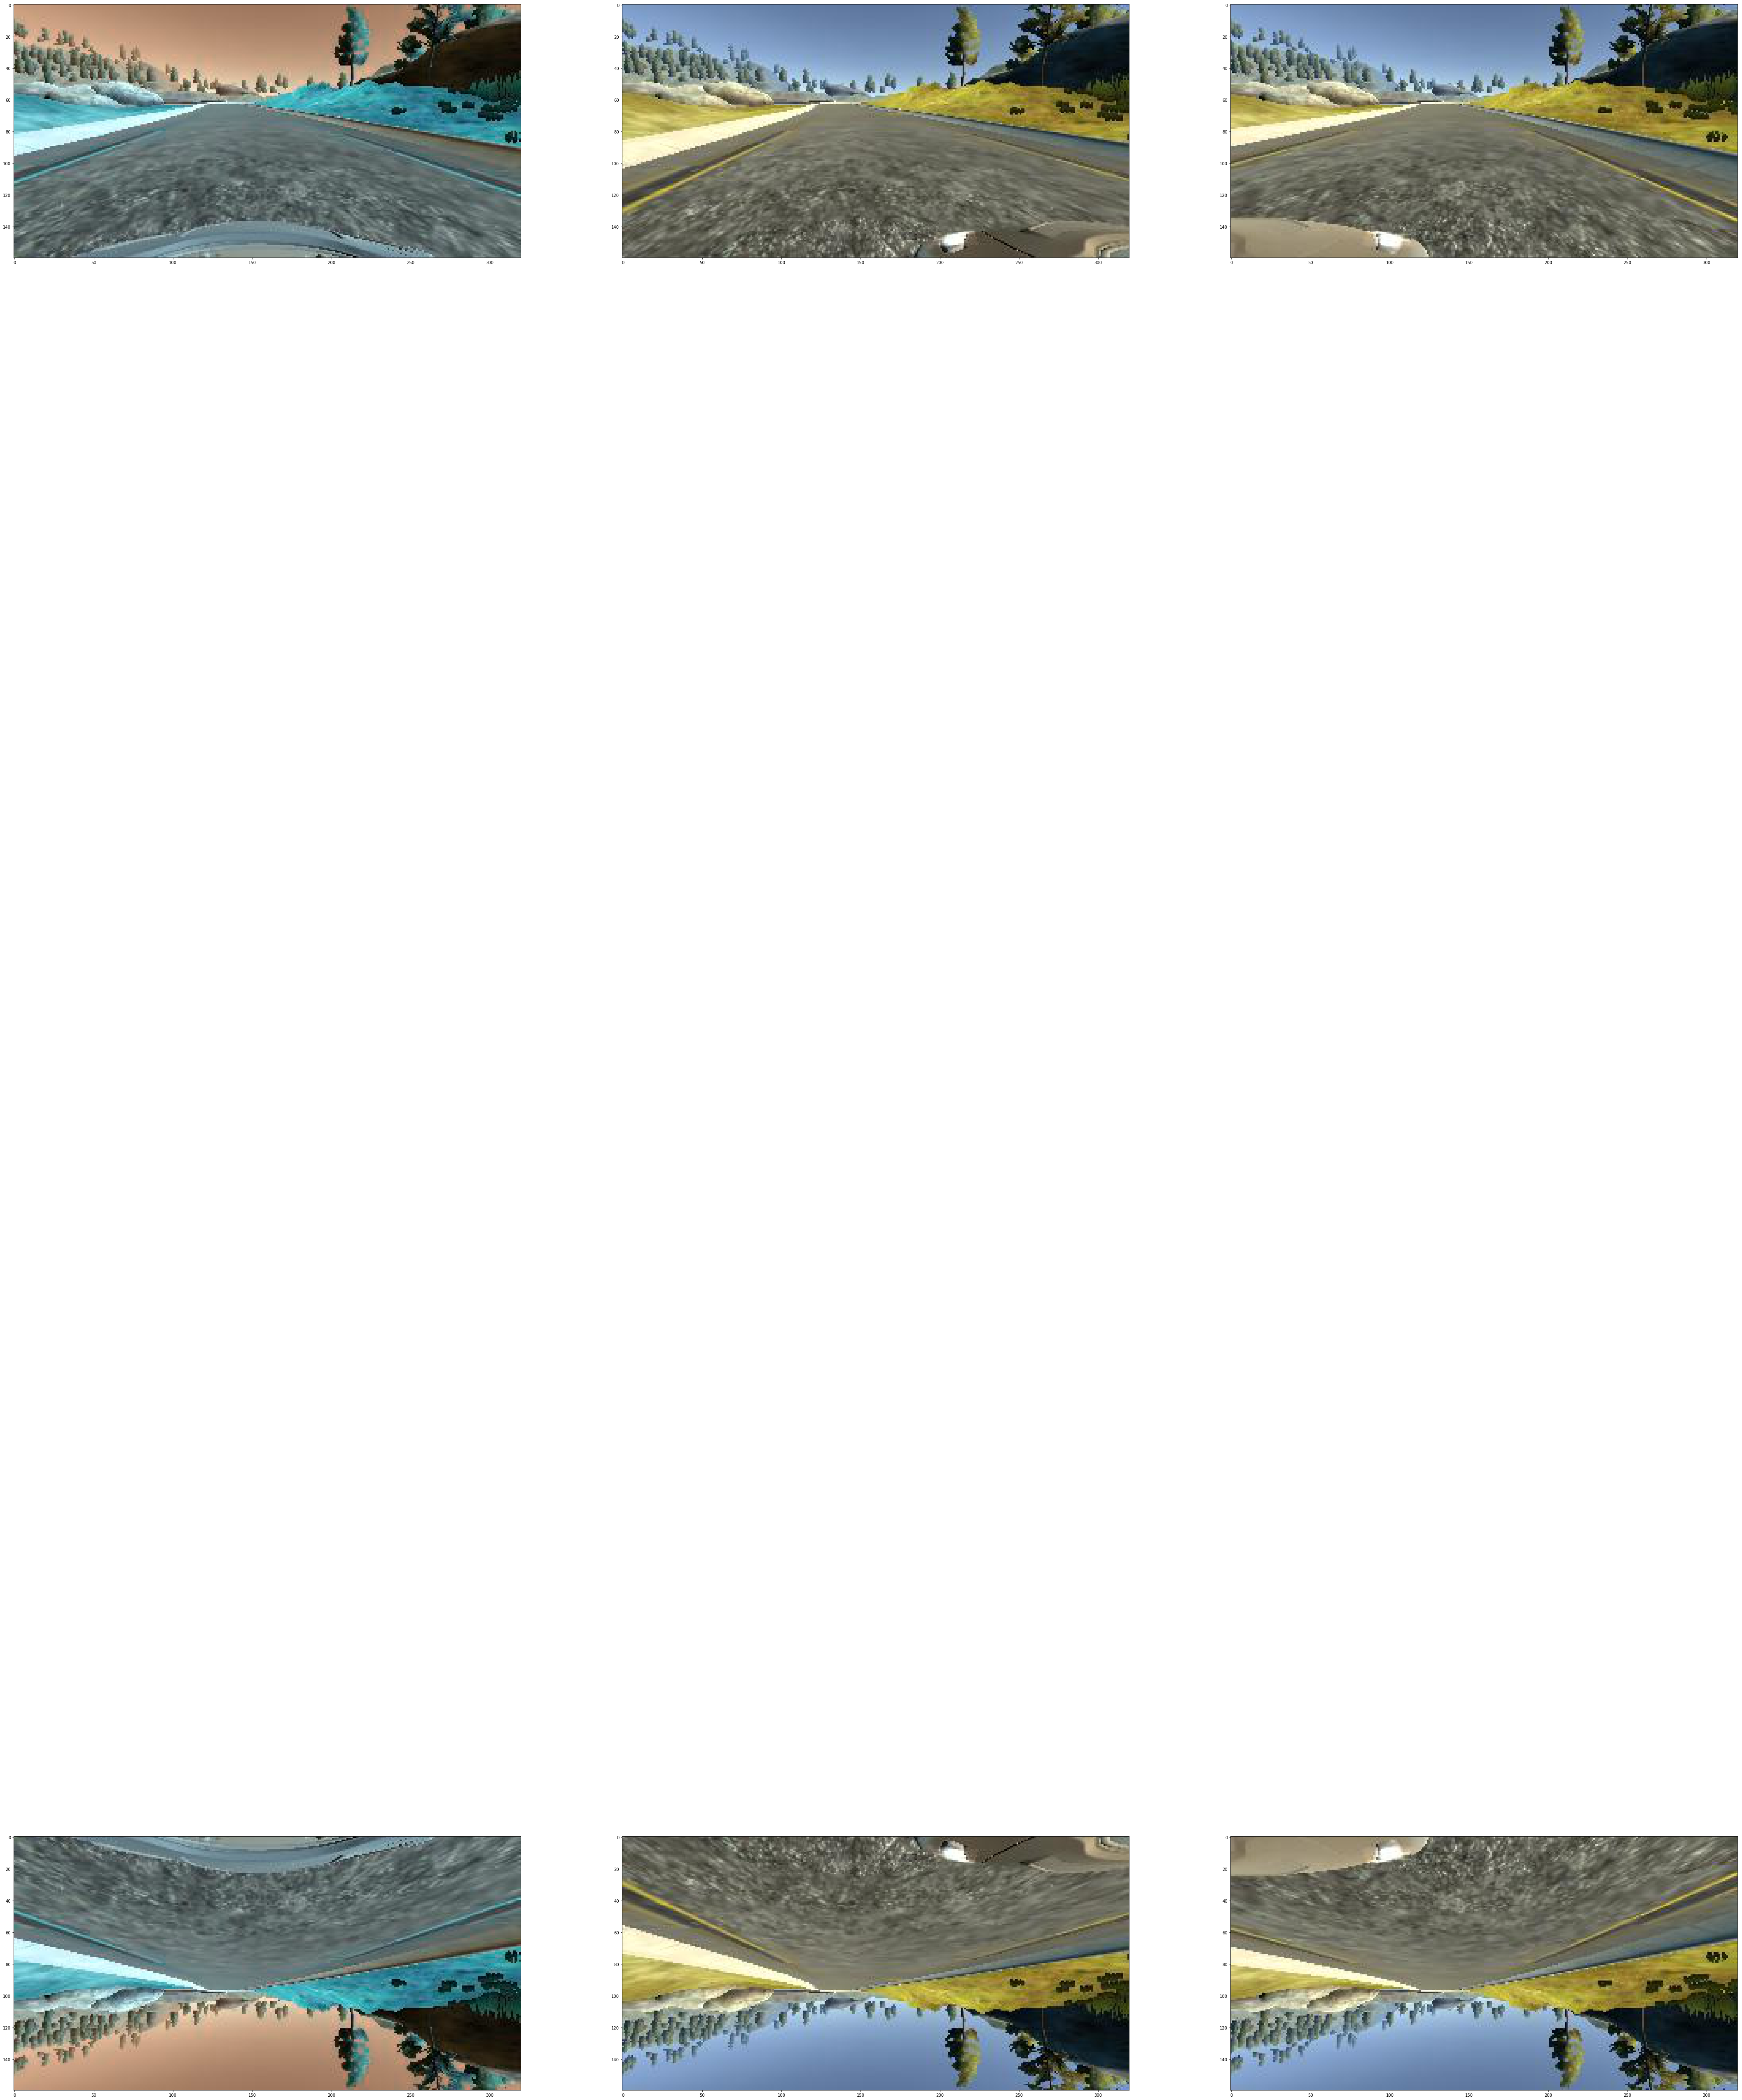

In [52]:
print(train_samples[0])
img_list = []
name = './data/IMG/' + train_samples[0][0].split('/')[-1]
center_image = cv2.imread(name)
left_image = read_image(train_samples[0][1])
right_image = read_image(train_samples[0][2])
img_list.append(center_image)
img_list.append(left_image)
img_list.append(right_image)

flip_output = horizontal_flip(center_image, 0)
img_list.append(flip_output[0])
flip_output = horizontal_flip(left_image, 0)
img_list.append(flip_output[0])
flip_output = horizontal_flip(right_image, 0)
img_list.append(flip_output[0])

fig = plt.figure(figsize=(75, 150))
# plt.imshow(center_image)
# plt.imshow(flip_image)
columns = 3
rows = 2
w=100
h=100
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_list[i-1])
plt.show()


